# `AA Workshop 09` - Decision Trees

In this workshop we get to know tree-based methods, which are commonly used in a myriad of classification and regression problems, and look at how to combine methods for ensembles.

We will cover the following: 
1. Decision Trees for classification (breast cancer example)
1. Decision Trees for regression (peak electrical power example)
1. Ensemble Methods

---

## Decision Trees

**Decision Trees (DTs)** are a non-parametric supervised learning method used for *classification* and *regression*. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the features.

Some **advantages** of decision trees are:

- Trees are simple to understand and to interpret. Trees can be visualised.

- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note, however, that missing values do need to be handled.

- Trees are able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. 

- Trees are able to handle multi-output problems.

- Trees are explainable. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in an opaque model (e.g., in an artificial neural network), results may be more difficult to interpret.

- It is possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.

- Trees perform well even if its assumptions are somewhat violated by the true model from which the data were generated.


The **disadvantages** of decision trees include:

- DT learners can create over-complex trees that do not generalise well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node, or setting the maximum depth of the tree are necessary to avoid this problem.

- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

- DT learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
np.set_printoptions(suppress=True)


%matplotlib inline

---

## Decision Trees for Classification: Classifying Breast Cancer Cells

In [2]:
# load dataset
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col="id")
cancer_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


To abstract from the relatively high-dimensionality of the breast cancer dataset let us confine our analysis to a two-dimensional feature vector consisting of `area_mean` and `concave points_mean` for now.

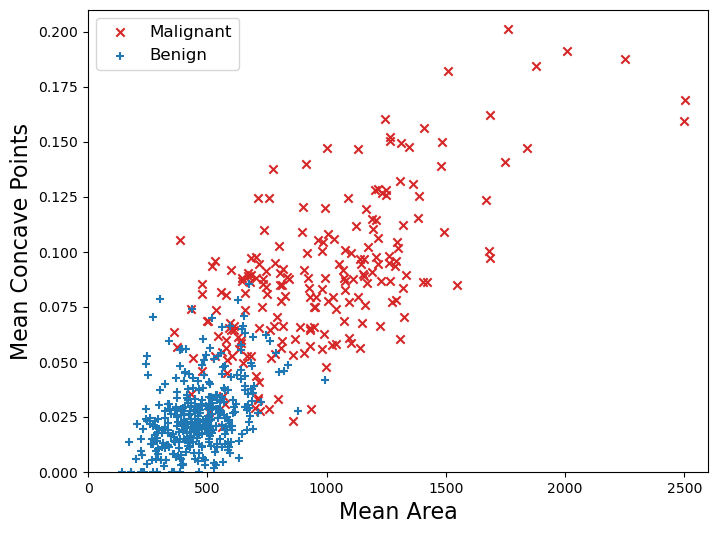

In [3]:
def plot_cells():
    plt.figure(figsize=(8,6))
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area",fontsize=16)
    plt.ylabel("Mean Concave Points",fontsize=16)
    plt.legend(['Malignant','Benign'],fontsize=12)
    
plot_cells()

We define X and Y vectors correspondingly:

In [4]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

# recode Y to 0 and 1
Y  = np.where(Y=="M", int(1), Y) 
Y  = np.where(Y=="B", int(0), Y) 
Y = Y.astype('int')

Note that we do not need to scale, as Decision Trees do not work based on distances across features!

Let's specify and fit a simple `DecisionTreeClassifier`, which is available via `sklearn`.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

tree_classifier = DecisionTreeClassifier(max_depth=3,criterion='gini') # we set gini as our impurity measure
tree_classifier.fit(X, Y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


The decision estimator has an attribute called `tree_`  which stores the entire tree structure and allows access to low-level attributes. The binary `tree_` attribute is represented as a number of parallel arrays. The i-th element of each array holds information about the node `i`. Node 0 is the tree's root.

In [6]:
structure = tree_classifier.tree_

Among those arrays, we have:

   - left_child: id of the left child of the node
   - right_child: id of the right child of the node
   - feature: feature used for splitting the node
   - threshold: threshold value used for splitting the node
   - impurity: the impurity at the node
   - etc.

In [7]:
# assign various tree attributes
n_nodes = structure.node_count
n_leaves = structure.n_leaves
children_left = structure.children_left
children_right = structure.children_right
feature = structure.feature
threshold = structure.threshold
impurity = structure.impurity

In [8]:
print("Num nodes: \t",n_nodes)
print("Num leaves: \t",n_leaves)

Num nodes: 	 15
Num leaves: 	 8


In [9]:
print("left children per node: ", children_left)
print("right children per node: ", children_right)
print("Decision feature at node: ", feature)
print("Threshold of feature at node", threshold)
print("Impurity at node: ", impurity)

left children per node:  [ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
right children per node:  [ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
Decision feature at node:  [ 1  0  1 -2 -2  0 -2 -2  0  1 -2 -2  1 -2 -2]
Threshold of feature at node [ 5.14199995e-02  6.96250000e+02  4.47000004e-02 -2.00000000e+00
 -2.00000000e+00  7.98899994e+02 -2.00000000e+00 -2.00000000e+00
  6.56500000e+02  7.94100016e-02 -2.00000000e+00 -2.00000000e+00
  6.23250008e-02 -2.00000000e+00 -2.00000000e+00]
Impurity at node:  [0.46753006 0.10804509 0.05290204 0.03124213 0.375      0.47530864
 0.32       0.46875    0.22214876 0.48661157 0.49975309 0.
 0.05876951 0.30839002 0.01379244]


The `apply` method can be used to get the index of the leaf that each sample is predicted as.

In [10]:
leaf_ids = tree_classifier.apply(X)

leaf_ids[:10]

array([14, 14, 14, 11, 14, 11, 14, 10, 11, 11])

Next let's retrieve the decision path of a selected sample. 

The `decision_path` method allows us to retrieve the node indicator functions. A non-zero element of an indicator matrix at the position (i, j) indicates that the sample i goes through the node j.

In [11]:
node_indicators = tree_classifier.decision_path(X)

# let's generate a random sample ID
sample_id = np.random.randint(0,len(X))

# retrieve decision_path for that sample
node_index = node_indicators.indices[node_indicators.indptr[sample_id]: #indptr maps the elements of data and indices to the rows of the sparse matrix
                                    node_indicators.indptr[sample_id + 1]]  #indptr maps the elements of data and indices to the rows of the sparse matrix

print("Decision path for sample " + str(sample_id), ": ", str(node_index))

Decision path for sample 156 :  [ 0  8 12 14]


In [12]:
print('Decision path for sample %s: %s' % (str(sample_id), str(node_index)))
print('Feature values of sample %s: %s \n' % (sample_id, X[sample_id]))
print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    # skip leaf node
    if leaf_ids[sample_id] == node_id:
        continue
    
    # for all other nodes, retrieve the feature values
    if (X[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("Decision at node %s: value for feature %s (%s) is %s the threshold of %s"
          % (node_id,
             feature[node_id],
             X[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Decision path for sample 156: [ 0  8 12 14]
Feature values of sample 156: [9.637e+02 1.054e-01] 

Rules used to predict sample 156: 
Decision at node 0: value for feature 1 (0.1054) is > the threshold of 0.051419999450445175
Decision at node 8: value for feature 0 (963.7) is > the threshold of 656.5
Decision at node 12: value for feature 1 (0.1054) is > the threshold of 0.06232500076293945


### Plot decision tree

Arguably this is a little abstract and does not seem very intuitive. Therefore, we will visualize the underlying tree and try to relate it back to the tree structure above.

In [13]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

def plot_class_tree_sklearn(tree_depth):

    model = DecisionTreeClassifier(max_depth=tree_depth,
                                  criterion='gini') # we set gini as our impurity measure
    model.fit(X, Y)
    
    dot_data = export_graphviz(model,
                               feature_names=['area_mean','concave points_mean'],
                              class_names = ["Begning","Malignant"],out_file=None)  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

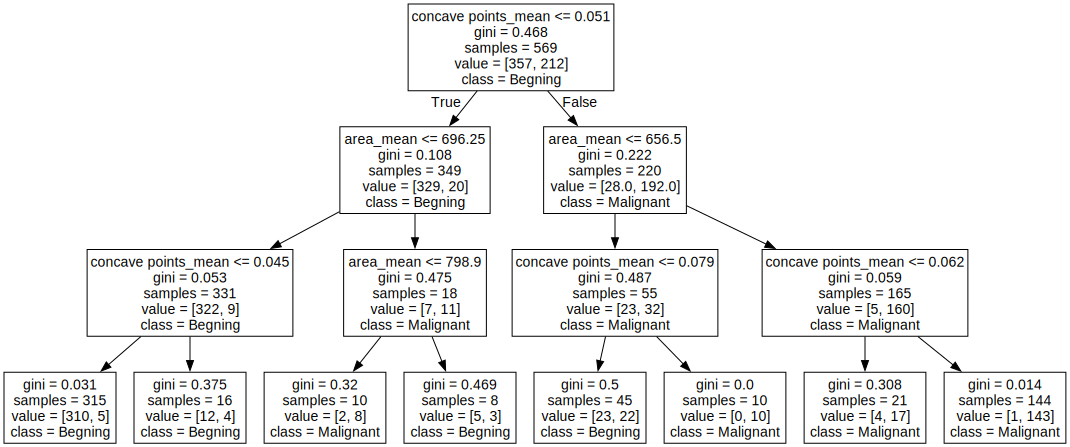

In [14]:
plot_class_tree_sklearn(3)

In the decision tree each node is represented by a box. For each node the following information is provided:
- decision feature and threshold
- impurity
- number of samples
- number of samples per class
- class (i.e., majority vote)

We can, thus, easily relate this back to the tree attributes we computed above. A selection is below:

In [15]:
print("Num nodes: \t",n_nodes)
print("Num leafs: \t",n_leaves)
print("Feature at node", feature) # -2 indicates no feature/threshold, i.e. a leaf
print("Threshold of feature at node", threshold)
print("Impurity at node: ", impurity)

Num nodes: 	 15
Num leafs: 	 8
Feature at node [ 1  0  1 -2 -2  0 -2 -2  0  1 -2 -2  1 -2 -2]
Threshold of feature at node [ 5.14199995e-02  6.96250000e+02  4.47000004e-02 -2.00000000e+00
 -2.00000000e+00  7.98899994e+02 -2.00000000e+00 -2.00000000e+00
  6.56500000e+02  7.94100016e-02 -2.00000000e+00 -2.00000000e+00
  6.23250008e-02 -2.00000000e+00 -2.00000000e+00]
Impurity at node:  [0.46753006 0.10804509 0.05290204 0.03124213 0.375      0.47530864
 0.32       0.46875    0.22214876 0.48661157 0.49975309 0.
 0.05876951 0.30839002 0.01379244]


### Plot decision surfaces

As we have seen in the lecture, another intuitive representation of decision trees is the use of decision surfaces. These can be related back directly to the decision tree. For ease of use, a plotting routine has been prepared that combines fitting and plotting into a single routine and allows for easy adjustment of tree depth and the minimum samples per leaf (discussed below).

In [16]:
def plot_class_surface(tree_depth):
    
    # specify and fit decision tree classifier
    #from sklearn.tree import DecisionTreeClassifier, export_graphviz # we also call the garphviz module for later visualization
    model = DecisionTreeClassifier(max_depth=tree_depth,
                                  criterion='gini') # we set entropy as our impurity measure
    model.fit(X, Y)
    
    # get tree attributes
    
    attributes = model.tree_
    
    # define range per feature
    x_range = [0,2600] # i.e. mean area
    y_range = [0, 0.21] # i.e mean conc. points
    plt.figure(figsize=(8,6))
    
    
    # plot classifcation regions
    grid=1000
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))


    zz = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = zz.reshape(xx.shape)
    cs = plt.contourf(xx, yy,zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')
    
    # plot datapoints
    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area",fontsize=16)
    plt.ylabel("Mean Concave Points",fontsize=16)
    plt.legend([s1,s2],['Malignant','Benign'],fontsize=12)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    
    plt.show()
    
    #plt.savefig("Breast_Cancer_Decision_Surface_{}depth.pdf".format(tree_depth))

number of nodes:  15
number of leafs:  8


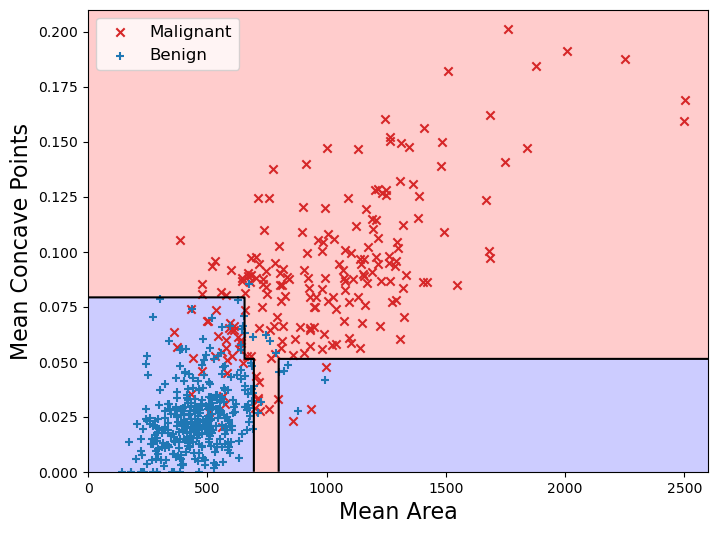

In [17]:
plot_class_surface(3)

### Controlling overfitting in Decision Trees

**Decision-tree learners can create overly complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.**

This can easily be seen by increasing tree depth to unreasonable values:

number of nodes:  103
number of leafs:  52


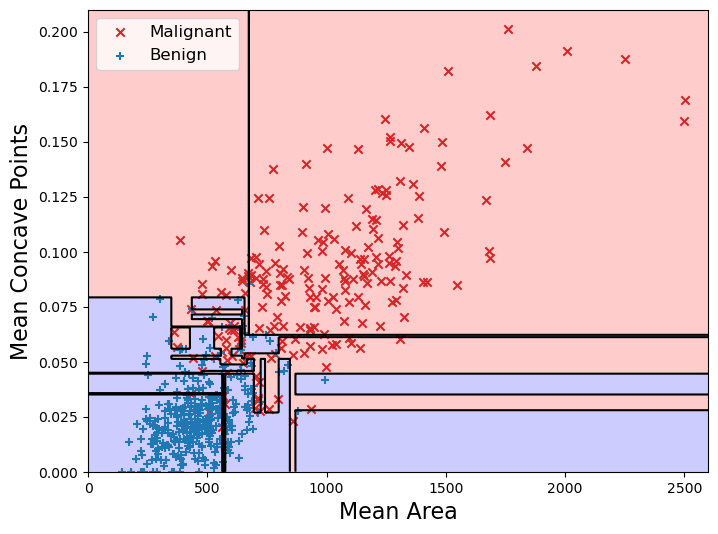

In [18]:
plot_class_surface(15)

What can we do about overfitting in sklearn? As mentioned, we have several tools at our disposal:
- **max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. A too high value of maximum depth causes overfitting, whereas a too low value causes underfitting.
- **min_samples_leaf**: By specifying a minimum number of samples per leaf, overfitting can be controlled for.
- **ccp_alpha**: Cost Complexity (CCP) alpha paramter determining the size of the penalty.

Let us look at the **cost complexity** as an effective measure in avoiding overfitting. The cost complexity of a tree (CCP(T)) is defined as 

\begin{equation}
CCP(T) = ERR(Z) + \alpha L(T)
\end{equation}

where ERR(Z) is the total misclassification rate of the terminal nodes and L(T) is the number of terminal nodes of tree T. This type of formula should look familiar, as it closely resembles the regularized regression loss functions we know.

To get an idea of what values of $\alpha$ could be appropriate, `scikit-learn` provides `DecisionTreeClassifier.cost_complexity_pruning_path` that returns the effective alphas (i.e., those that will achieve the next step in complexity reduction) and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

# fit decision tree (without limit on max_depth, i.e. tree will grow fully if alpha is set to 0)
tree_classifier = DecisionTreeClassifier(random_state=0, 
                                         criterion="gini")

# compute cost_complexity_pruning_path 
path = tree_classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [20]:
# return path
path

{'ccp_alphas': array([0.        , 0.00176056, 0.00195618, 0.00205399, 0.00223564,
        0.00229283, 0.00230624, 0.00234045, 0.00289975, 0.00304859,
        0.0031951 , 0.00358596, 0.00383565, 0.00457548, 0.00485534,
        0.00652311, 0.01323716, 0.01731205, 0.32729844]),
 'impurities': array([0.        , 0.00352113, 0.00938967, 0.01349765, 0.02020456,
        0.02479021, 0.02940268, 0.03408358, 0.04568259, 0.05177978,
        0.05497487, 0.06573274, 0.08491099, 0.09863742, 0.10349276,
        0.11001587, 0.12325303, 0.14056508, 0.46786352])}

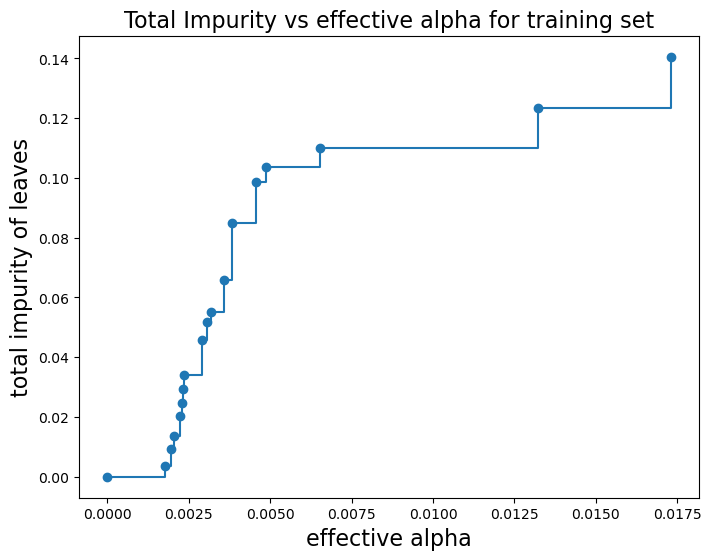

In [21]:
# plot cost_complexity_pruning_path
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  # we remove the last alpha as this corresponds to a tree with only the root node
ax.set_xlabel("effective alpha",fontsize=16)
ax.set_ylabel("total impurity of leaves",fontsize=16)
ax.set_title("Total Impurity vs effective alpha for training set",fontsize=16)
plt.show()

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree with one node.

In [22]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.32729844193277774


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

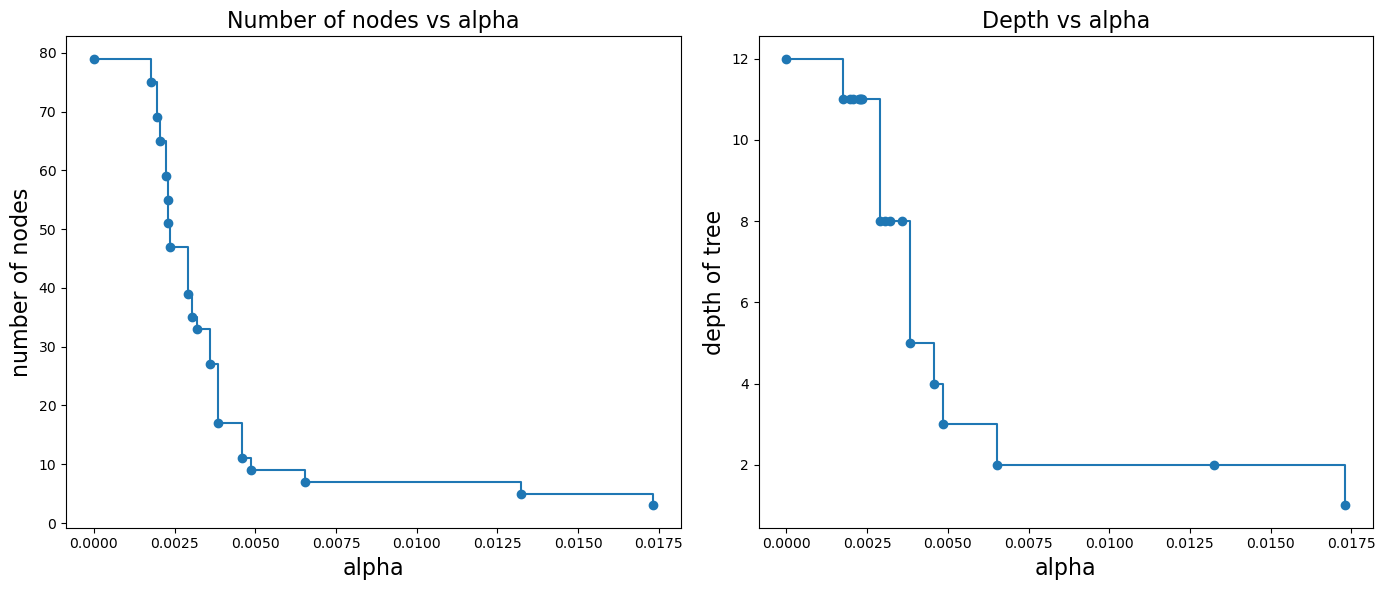

In [23]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha",fontsize=16)
ax[0].set_ylabel("number of nodes",fontsize=16)
ax[0].set_title("Number of nodes vs alpha",fontsize=16)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha",fontsize=16)
ax[1].set_ylabel("depth of tree",fontsize=16)
ax[1].set_title("Depth vs alpha",fontsize=16)
fig.tight_layout()
plt.show()

In [24]:
len(ccp_alphas)

18

Now, we could implement a grid search over the identified effective alphas to determine where predictive performance is maximized (see coding challenge for this workshop).

---

## Decision Trees for Regression: Predicting Peak Electricity Demand

We continue with our electric power example from last week which we retieved from PJM from the following link [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv`.

In [25]:
# load data
df = pd.read_csv("../data/Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].apply(lambda x: x.month)
df.head()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
0,2013-01-01,1.598524,1.859947,0.001599,38.368031,0.0,-1.68,1
1,2013-01-02,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58,1
2,2013-01-03,1.832822,2.049550,0.001833,43.991607,0.6,-6.12,1
3,2013-01-04,1.812699,2.008168,0.001813,43.508609,0.0,-1.95,1
4,2013-01-05,1.662036,1.838251,0.001662,39.892360,1.7,-1.47,1


In [26]:
# define x and y vectors
Xp = df["High_temp"].values
Yp = df["MAX"].values

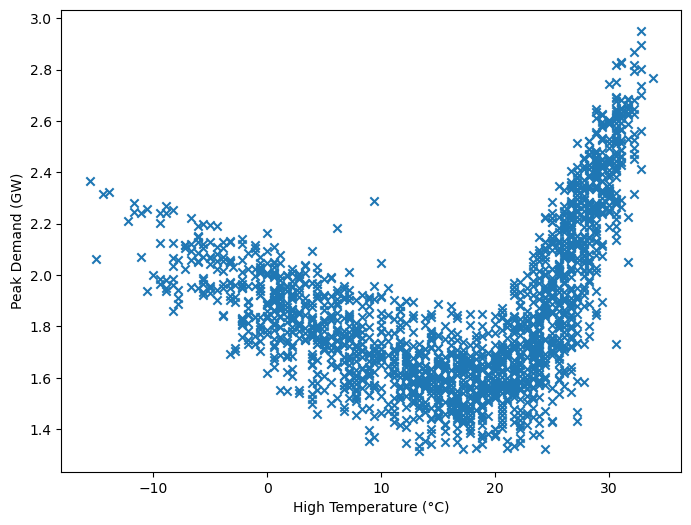

In [27]:
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

We will unse the `DecisionTreeRegressor` class in `scikit-learn` to fit and plot a decision tree regressor.

In [28]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="squared_error")
    Tree_reg.fit(Xp.reshape((-1,1)), Yp)
    Y_pred = Tree_reg.predict(Xp.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("High Temperature (°C)", fontsize=16)
    plt.ylabel("Peak Demand (GW)", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(Yp, Y_pred))

number of nodes:  127
number of leafs:  64
R^2:  0.7605609145871184


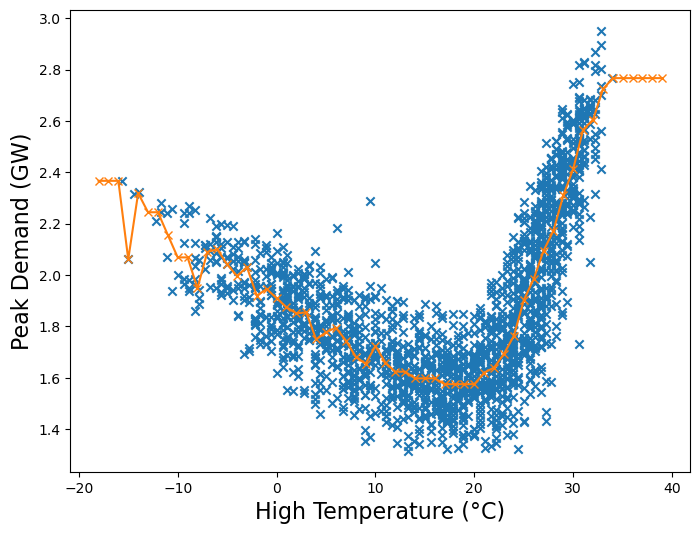

In [29]:
plot_tree_regression_line(8)

In [30]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(Xp.reshape((-1,1)), Yp) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

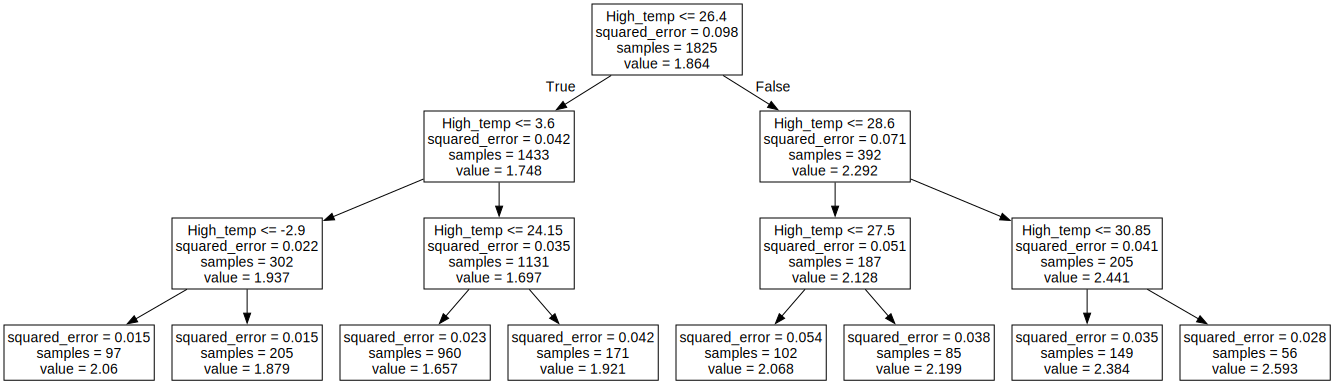

In [31]:
plot_regression_tree_sklearn(3)

---

## Ensemble Methods

In predictive modeling, “risk” is equivalent to variation (i.e. variance) in prediction error. Ensemble methods are targeted at reducing variance, thus increasing predictive power.
The core idea is that by combining the outcomes of individual models, e.g., by taking an average, variance may be reduced. Thus, using an average of two or more predictions can potentially lead to smaller error variance, and therefore better predictive power.

We will discuss three forms of ensemble learning:
- Bagging
- Boosting
- Random Forests

Let's start applying the above method on the classification problem of the *breast cancer* dataset:

In [32]:
# load data
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col="id")
cancer_df.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [33]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

Y  = np.where(Y=="M", int(1), int(0))
Y = Y.astype('int')

In [34]:
# train test split on breast cancer dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

### Boosting
The goal in boosting is to directly improve areas in the data where our model makes errors by forcing the model to pay more attention to those records. 

Boosting involves incrementally building an ensemble by training each new model instance to emphasize the training instances that previous models misclassified. In some cases, boosting has been shown to yield better accuracy than bagging (see next section), but it also tends to be more likely to overfit the training data. By far the most common implementation of boosting is Adaboost, although some newer algorithms are reported to achieve better results.

In boosting, an equal weight (uniform probability distribution) is given to the sample training data (say D1) at the starting round. This data (D1) is then given to a base learner (say L1). The misclassified instances by L1 are assigned a weight higher than the correctly classified instances, but keeping in mind that the total probability distribution will be equal to 1. This boosted data (say D2) is then given to second base learner (say L2) and so on. The results are then combined in the form of voting.
The steps in boosting are:

1. Fit a model to the data.
2. Draw a sample from the data so that misclassified records (or records with large prediction errors) have higher probabilities of selection.
3. Fit the model to the new sample.
4. Repeat Steps 2–3 multiple times.

#### AdaBoost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [35]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train, y_train)
model.score(X_test,y_test) # return the mean accuracy on the given test data and labels

0.9090909090909091

#### Gradient Boosting

Gradient boosting is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. If a small change in the prediction for a case causes no change in error, then the next target outcome of the case is zero.
GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage, ``n_classes_`` trees are fitted on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single tree is induced.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=1000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9230769230769231

#### XGBoost

XGBoost is an ensemple method that uses boosting. While XGBoost is not included in sklearn, there is a very well developed API that can interface with sklearn.
We assume you have the appropriate package installed (if you are using the `environment.yml`, you should be set.)
For further details refere to
- XGBoost: see [here](https://xgboost.readthedocs.io/en/latest/)

Let us fit a simple classifier to the breast cancer dataset.

In [37]:
# sepcify and fit model
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(booster="gbtree")
xgb_classifier.fit(X_train,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


We can use the usual sklearn estimator API:

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test,xgb_classifier.predict(X_test))

array([[79, 10],
       [ 5, 49]])

In [39]:
accuracy_score(y_test,xgb_classifier.predict(X_test))

0.8951048951048951

Obviously, there is likely room for improvement as you grid search some of the hyperparameters. However, by just taking the default setting, we already achieve an accuracy score that is comparable to that of a grid-searched decision tree.

### Bagging

Bootstrap aggregating, often abbreviated as bagging, involves having each model in the ensemble vote with equal weight. In order to promote model variance, bagging trains each model in the ensemble using a randomly drawn subset of the training set. As an example, the random forest algorithm combines random decision trees with bagging to achieve very high classification accuracy.

In bagging the samples are generated in such a way that the samples are different from each other, but replacement is allowed. Replacement means that an instance can occur in multiple samples multiple times or it can not appear in some samples at all. These samples are then given to multiple learners and the results from each learner are combined in the form of voting. Bagging comprises two steps:
1. Generate multiple random samples (by sampling with replacement from the original data) — this method is called “bootstrap sampling.”
2. Running an algorithm on each sample and producing scores.

This technique is very useful for algorithms such as trees and neural networks.

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

model = BaggingClassifier(estimator=
    tree.DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=1), 
    max_samples=0.5, 
    max_features=0.5, random_state = 42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.9020979020979021

### Random Forests

Random Forests is a selection of n trees which are trained in parallel. Predictions are made by averaging the outputs across these n trees. Random Forest are most often combined with **bagging**, i.e. different boostrap samples of the training data are used to train the individual trees.

Further details can be found in the following links [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [41]:
from sklearn.ensemble import RandomForestClassifier

# sepcify and fit model

rf_classifier = RandomForestClassifier(n_estimators=10000, 
                                       bootstrap=True) # we select boostrapp, i.e. we use bagging
rf_classifier.fit(X_train,y_train)

,n_estimators,10000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test,rf_classifier.predict(X_test))

array([[79, 10],
       [ 3, 51]])

In [43]:
accuracy_score(y_test,rf_classifier.predict(X_test))

0.9090909090909091

Again, just by taking the default setting, we obtain very good results that are comparable to those of the fully grid-searched decision tree.

---